<a href="https://colab.research.google.com/github/hws1302/partII-computing-exercises/blob/main/exercise2_hs723_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 2: Integration and Vectorisation (hs723)

Aim to evaluate integrals numerically:

a) self written Monte-Carlo algorithm \
b) general purpose integrator using `scipy`

In [1]:
# first, import the essential libraries 
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy.integrate

## Core task 1 

approximate the value of the following integral using your own Monte-Carlo method. 

$$10^6 \int_{0}^{s}\int_{0}^{s}\int_{0}^{s}\int_{0}^{s}\int_{0}^{s}\int_{0}^{s}\int_{0}^{s}\int_{0}^{s} \sin(x_0 + x_1 + x_2 + x_3 + x_4 + x_5 + x_6 + x_7) dx_0dx_1dx_2dx_3dx_4dx_5dx_6dx_7 \approx 537.1873411$$

$$\text{with}:  s = \frac{\pi}{8}$$

In [2]:
def monte_carlo_integration(N: int, batch_size: int):
    """
    Return estimate of the octuple sine integral for given number of random samples

              Parameters:
                      N (int): number of random samples taken in the hypervolume 
                      batch_size (int): the number of random points to do at once i.e. vectorsation

              Returns:
                      estimate (float): estimate of the integral, as average of the points 
                      error_estimate (float): error estimate using the formula given in handout
    """

    f = 0 
    f_sq = 0 

    N = (N // batch_size) * batch_size # split 

    for _ in range(N // batch_size):

        point_batch = np.random.rand(8,batch_size) * pi/8 # this gives us a batch of points

        point_sum = 10**6 * np.sin(np.sum(point_batch, axis=0))

        f += np.sum(point_sum)

        f_sq += np.sum(np.square(point_sum))

    f /= N

    f_sq /= N 

    error = (pi/8)**8 * ( (f_sq - f**2) / N )**0.5

    estimate = (pi/8)**8 * f 

    return estimate, error

Now we have a function that can make an estimate to the integral using $N$ samples - we can call this $n$ times to get better estimates of the integral.

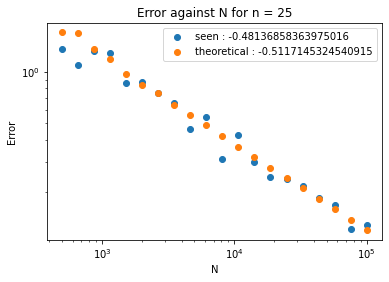

In [3]:
Ns = np.geomspace(501, 100000, 20).astype(int)
n = 25
theoretical_errors = np.empty(len(Ns)) 
seen_errors = np.empty(len(Ns))

for i, N in enumerate(Ns): # N number of samples

    errors = np.empty(n)
    estimates = np.empty(n)

    for j in range(n): # do n samples of each N integral

        estimate, error = monte_carlo_integration(N,250)

        estimates[j] = estimate
        errors[j] = error

    seen_errors[i] = np.std(estimates)
    theoretical_errors[i] = np.mean(errors)

# find the line of best fit for loglog relation
seen_grad, _ = np.polyfit(np.log(Ns), np.log(seen_errors), deg=1)
theoretical_grad, _ = np.polyfit(np.log(Ns), np.log(theoretical_errors), deg=1)

# plot the theoretical errors from handout eqn and the std in the estimates against N
plt.scatter(Ns, seen_errors, label=f'seen : {seen_grad}')
plt.scatter(Ns, theoretical_errors, label=f'theoretical : {theoretical_grad}')
plt.title('Error against N for n = 25')
plt.xlabel('N')
plt.ylabel('Error')
plt.loglog()
plt.legend()
plt.show()

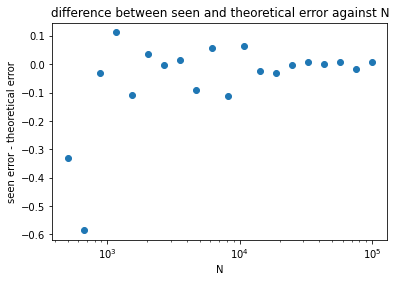

In [4]:
plt.scatter(Ns, seen_errors - theoretical_errors)
plt.xscale('log')
plt.title('difference between seen and theoretical error against N')
plt.xlabel('N')
plt.ylabel('seen error - theoretical error')
plt.show()

In [5]:
# N = 10000 integral estimate
np.mean(estimates)

537.189158493951

In [6]:
#largest value of N that can be done in 1 min
n = 25 
N = int(1e7)

errors = np.empty(n)
estimates = np.empty(n)

for i in tqdm(range(n)):
# when we only have one value of N can increase the batch size massively
    estimate, error = monte_carlo_integration(N, N)

    estimates[i] = estimate
    errors[i] = error

seen_errors = np.std(estimates)
theoretical_errors = np.mean(errors)

100%|██████████| 25/25 [00:36<00:00,  1.47s/it]


In [7]:
# this value is very small for large N
abs(theoretical_errors - seen_errors)

0.0003059689205526274

##Core task 1 conclusion 

We can estimate the value of the integral and errors using `monte_carlo_integration` function 

- The errors (i.e. std dev of the estimates and mean of the theoretical errors) falls of roughly with $N^{-\frac{1}{2}}$ as expected (see legend) 

- As $N$ increases the difference between the theoretical error (from handout) and the seen error decreases. This is good as the theory and the seen errors should converge as $N → ∞$

- For 10 million samples averaged over 25 runs the difference between seen and theoretical errors is of order $10^{-3}$

## Core task 2 
evaluate Fresnel integrals using `scipy`.
Here we don't use a Monte-Carlo routine as it is ineffcient for low-dimensional integrals.

Although there is a `scipy.special.fresnel` we are using `scipy.integrate.quadrature` to show understanding of the task at hand. We can then plot the Cornu spirals using `pyplot`. 


The integrals to compute are:


$$C(u) = \int_0^u\cos \left( \frac{\pi x^2}{2} \right)dx$$

$$S(u) = \int_0^u\sin \left( \frac{\pi x^2}{2} \right)dx$$


The Cornu spiral can be plotted by plotting the line $C + iS$ over a range of $u$ values.

Now using `scipy.integrate.quadrature` lets try and build a similar function

In [8]:
# define the integrands
real = lambda u: np.cos(pi * u**2 / 2)
imaginary = lambda u: np.sin(pi * u**2 / 2)

In [9]:
def cornu_integrate(Us):
    """
    Return C and S integrals for Cornu spiral using `scipy.integrate.quadrature'

              Parameters:
                      Us (numpy.ndarray): values at which the integrals will be evaluated (numpy.arange or numpy.linspace recommended)

              Returns:
                      C (numpy.ndarray): array of values for cosine Fresnel integral
                      S (numpy.ndarray): array of values for sine Fresnel integral
    """
    C = np.empty(len(Us))
    S = np.empty(len(Us))

    for i, u in enumerate(Us):

      C[i] = scipy.integrate.quadrature(real, 0, u)[0]

      S[i] = scipy.integrate.quadrature(imaginary, 0, u)[0]

    return C, S

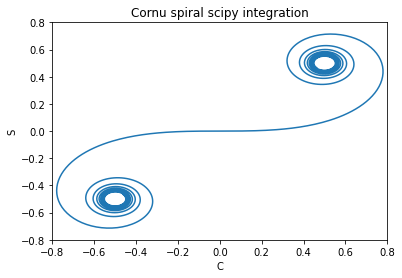

In [10]:
Us = np.linspace(-2 * np.pi, 2 * np.pi, 1000)
C, S = cornu_integrate(Us)

plt.plot(C, S)
plt.title('Cornu spiral scipy integration')
plt.xlabel('C')
plt.ylabel('S')
plt.xlim(-0.8,0.8)
plt.ylim(-0.8,0.8)
plt.show()

If we compare this function with the built-in `scipy.integrate.fresnel` function we see that our function does a great job

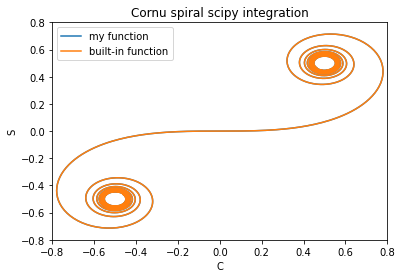

In [11]:
S_prime, C_prime = scipy.special.fresnel(Us)

plt.plot(C, S, label='my function')
plt.plot(C_prime, S_prime, label='built-in function')
plt.title('Cornu spiral scipy integration')
plt.xlabel('C')
plt.ylabel('S')
plt.xlim(-0.8,0.8)
plt.ylim(-0.8,0.8)
plt.legend()
plt.show()

##Core task 2 conclusion 

We saw that using `scipy.integrate.quadtrature` we could produce the Cornu spiral shape as expected 

##Supplementary task 1 
We can produce a non-vectorised version of the `monte_carlo_integration` (with same logic) and compare speeds using `%timeit`

In [12]:
def non_vectorised_monte_carlo_integration(N: int):
    """
    Return estimate of the octuple sine integral for given number of random samples

              Parameters:
                      N (int): number of random samples taken in the hypervolume 

              Returns:
                      estimate (float): estimate of the integral, as average of the points 
                      error (float): error estimate using the formula given in the book
    """

    tot = 0 
    tot_sq = 0 

    for _ in range(N):

        coordinates = []

        for _ in range(8):

          coordinates.append(np.random.rand() * pi/8)

        coordinate_sum = 0 

        for coordinate in coordinates:

          coordinate_sum += coordinate 

        point_value = np.sin(coordinate_sum)

        tot += point_value

        tot_sq += point_value ** 2

    estimate = 1/N * tot * (pi/8)**8

    square_average = 1/N * tot_sq

    error = (pi/8)**8 *((square_average - estimate)/N)**0.5

    return estimate, error

In [13]:
# first of all we can see that we should use a batch size as big as possible
N = int(1e4)

%timeit monte_carlo_integration(N, N)
%timeit monte_carlo_integration(N, 100)

1000 loops, best of 5: 1.15 ms per loop
100 loops, best of 5: 3.39 ms per loop


In [14]:
%timeit non_vectorised_monte_carlo_integration(N) 
%timeit monte_carlo_integration(N, N) # with the cell above in mind use batch size as big as possible i.e. the hole N in one go

10 loops, best of 5: 65.9 ms per loop
1000 loops, best of 5: 1.25 ms per loop


##Supplemenatry task 1 conclusion 
As seen, if we vectorise everywhere we can, the function runs ~$50$x quicker. Vectorisation is definitely worth some putting a good amount of thought into!

## Supplementary task 2 

Can express pendulum swinging with amplitude $\theta_m$

$$T = \sqrt{\frac{8l}{g}} \int_0^{\theta_m} \frac{d\theta}{\sqrt{\cos \theta - \cos \theta_m }}$$

Use quadrature integrator to calculate and plot the period as a function of the amplitude of the swing.

In [15]:
# define an anonymous function, here we are integrating over x and t is a constant 
func = lambda x, t: 1 / np.sqrt(np.cos(x) - np.cos(t))

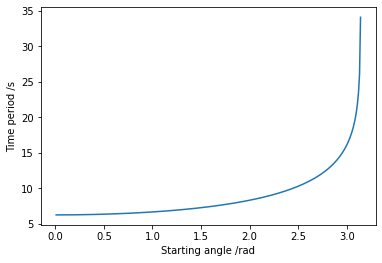

In [16]:
# we must starting slightly after 0 to avoid divison by zero and stop slightly before pi to avoid infinite time soln.
Us = np.arange(0.01, np.pi, 0.01) 
Ts = np.empty(len(Us))

for i, u in enumerate(Us): # we are currently dividing by 

  Ts[i] = scipy.integrate.quad(func, 0, u, args=u)[0]

Ts *= np.sqrt(8) # taking g = l as in exercise 1

plt.plot(Us, Ts)
plt.xlabel('Starting angle /rad')
plt.ylabel('Time period /s')
plt.show()

We can copy over the data from task 1 and see how they compare

In [17]:
# copied over the data from the same task in the previous exercise

Ts_exercise1 = np.array([ 6.27187331,  6.27187331,  6.27187331,  6.27187331,  6.27187331,
        6.27187331,  6.29701108,  6.29701108,  6.29701108,  6.29701108,
        6.29701108,  6.29701108,  6.29701108,  6.29701108,  6.29701108,
        6.29701108,  6.29701108,  6.29701108,  6.29701108,  6.29701108,
        6.29701108,  6.29701108,  6.29701108,  6.29701108,  6.29701108,
        6.29701108,  6.32214885,  6.32214885,  6.32214885,  6.32214885,
        6.32214885,  6.32214885,  6.32214885,  6.32214885,  6.32214885,
        6.32214885,  6.34728662,  6.34728662,  6.34728662,  6.34728662,
        6.34728662,  6.34728662,  6.34728662,  6.34728662,  6.37242439,
        6.37242439,  6.37242439,  6.37242439,  6.37242439,  6.37242439,
        6.39756216,  6.39756216,  6.39756216,  6.39756216,  6.39756216,
        6.39756216,  6.42269992,  6.42269992,  6.42269992,  6.42269992,
        6.42269992,  6.44783769,  6.44783769,  6.44783769,  6.44783769,
        6.44783769,  6.47297546,  6.47297546,  6.47297546,  6.47297546,
        6.49811323,  6.49811323,  6.49811323,  6.49811323,  6.523251  ,
        6.523251  ,  6.523251  ,  6.523251  ,  6.54838877,  6.54838877,
        6.54838877,  6.54838877,  6.57352654,  6.57352654,  6.57352654,
        6.59866431,  6.59866431,  6.59866431,  6.59866431,  6.62380207,
        6.62380207,  6.62380207,  6.64893984,  6.64893984,  6.64893984,
        6.67407761,  6.67407761,  6.67407761,  6.69921538,  6.69921538,
        6.69921538,  6.72435315,  6.72435315,  6.72435315,  6.74949092,
        6.74949092,  6.77462869,  6.77462869,  6.77462869,  6.79976646,
        6.79976646,  6.82490422,  6.82490422,  6.82490422,  6.85004199,
        6.85004199,  6.87517976,  6.87517976,  6.90031753,  6.90031753,
        6.90031753,  6.9254553 ,  6.9254553 ,  6.95059307,  6.95059307,
        6.97573084,  6.97573084,  7.00086861,  7.00086861,  7.02600637,
        7.02600637,  7.05114414,  7.05114414,  7.07628191,  7.07628191,
        7.10141968,  7.10141968,  7.12655745,  7.12655745,  7.15169522,
        7.17683299,  7.17683299,  7.20197076,  7.20197076,  7.22710852,
        7.22710852,  7.25224629,  7.27738406,  7.27738406,  7.30252183,
        7.3276596 ,  7.3276596 ,  7.35279737,  7.35279737,  7.37793514,
        7.40307291,  7.40307291,  7.42821068,  7.45334844,  7.47848621,
        7.47848621,  7.50362398,  7.52876175,  7.52876175,  7.55389952,
        7.57903729,  7.60417506,  7.60417506,  7.62931283,  7.65445059,
        7.67958836,  7.67958836,  7.70472613,  7.7298639 ,  7.75500167,
        7.78013944,  7.80527721,  7.80527721,  7.83041498,  7.85555274,
        7.88069051,  7.90582828,  7.93096605,  7.95610382,  7.98124159,
        7.98124159,  8.00637936,  8.03151713,  8.05665489,  8.08179266,
        8.10693043,  8.1320682 ,  8.15720597,  8.18234374,  8.20748151,
        8.23261928,  8.25775705,  8.30803258,  8.33317035,  8.35830812,
        8.38344589,  8.40858366,  8.43372143,  8.4588592 ,  8.48399696,
        8.5342725 ,  8.55941027,  8.58454804,  8.60968581,  8.63482358,
        8.68509911,  8.71023688,  8.73537465,  8.78565019,  8.81078796,
        8.83592573,  8.88620126,  8.91133903,  8.9364768 ,  8.98675234,
        9.01189011,  9.06216565,  9.08730341,  9.13757895,  9.16271672,
        9.21299226,  9.23813003,  9.28840557,  9.31354333,  9.36381887,
        9.41409441,  9.43923218,  9.48950772,  9.53978325,  9.56492102,
        9.61519656,  9.6654721 ,  9.71574763,  9.76602317,  9.79116094,
        9.84143648,  9.89171202,  9.94198755,  9.99226309, 10.04253863,
       10.09281417, 10.16822747, 10.21850301, 10.26877855, 10.31905409,
       10.36932962, 10.44474293, 10.49501847, 10.545294  , 10.62070731,
       10.67098285, 10.74639615, 10.82180946, 10.872085  , 10.9474983 ,
       11.02291161, 11.07318715, 11.14860046, 11.22401376, 11.29942707,
       11.37484037, 11.45025368, 11.55080476, 11.62621806, 11.70163137,
       11.80218244, 11.87759575, 11.97814682, 12.0786979 , 12.17924898,
       12.27980005, 12.38035113, 12.4809022 , 12.58145328, 12.70714212,
       12.80769319, 12.93338204, 13.05907088, 13.18475973, 13.31044857,
       13.43613741, 13.58696403, 13.73779064, 13.88861725, 14.03944387,
       14.21540825, 14.39137263, 14.56733701, 14.76843916, 14.96954131,
       15.17064346, 15.39688338, 15.6231233 , 15.89963875, 16.15101644,
       16.45266967, 16.75432289, 17.10625166, 17.48331819, 17.88552249,
       18.33800233, 18.86589547, 19.46920192, 20.17305945, 21.02774359,
       22.13380541, 23.64207154, 26.13071065, 34.07424558]);

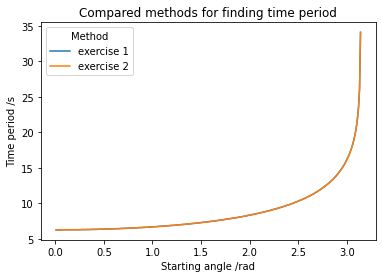

In [18]:
plt.plot(Us, Ts_exercise1, label='exercise 1')
plt.plot(Us, Ts, label='exercise 2')
plt.xlabel('Starting angle /rad')
plt.ylabel('Time period /s')
plt.legend(title='Method')
plt.title('Compared methods for finding time period')
plt.show()

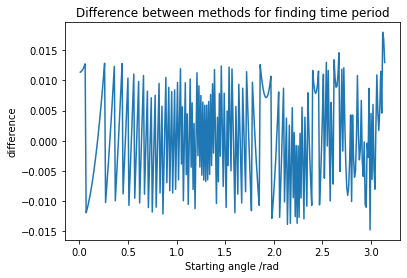

In [19]:
plt.plot(Us, Ts - Ts_exercise1)
plt.xlabel('Starting angle /rad')
plt.ylabel('difference')
plt.title('Difference between methods for finding time period')
plt.show()

##Supplementary task 2 conclusion 

We can see from the above plot that the two methods provid very similar result. We could improve on this by reducing the allowed error for the integral method or allow there to be more points sampled per oscillation for the method from exercise 1. 